In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
#!unzip "/content/drive/My Drive/Assignment 5 Dataset.zip"

In [0]:
data_dir = '/content/Assignment 5 Dataset'

In [31]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data=datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)  ##Train-Transform to the Validation data also
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True,num_workers=8)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=128, shuffle=True,num_workers=8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True,num_workers=8)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [5]:
'''
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
'''

"\ndef imshow(inp, title=None):\n    inp = inp.numpy().transpose((1, 2, 0))\n    plt.axis('off')\n    plt.imshow(inp)\n    if title is not None:\n        plt.title(title)\n    plt.pause(0.001)\n\ndef show_databatch(inputs, classes):\n    out = torchvision.utils.make_grid(inputs)\n    imshow(out, title=[class_names[x] for x in classes])\n\n# Get a batch of training data\ninputs, classes = next(iter(trainloader))\nshow_databatch(inputs, classes)\n"

In [0]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] #Remove Last Layer

features.extend([nn.Linear(num_features, 550)])
features.extend([nn.Linear(550, len(class_names))]) #Last output is 2. 
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
def validate(mdl,device):
  correct = 0
  total = 0
  los=0
  with torch.no_grad():
      for data in validationloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = mdl(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)
          los+=  loss.item()
  
  print('Accuracy of the network on the Validation images: %d %%' % (100 * correct / total))
  print('Loss of the network on the Validation images:',los)
  return los,correct / total


In [0]:
def confusion_matrix(y_pred,y_true):
  from sklearn.metrics import confusion_matrix
  tn, fp, fn, tp=confusion_matrix(y_true,y_pred).ravel()
  return tn, fp, fn, tp


In [0]:
def test(mdl,device):
  correct = 0
  total = 0
  tst_loss_vect=[]
  tst_accu_vect=[]
  los=0
  with torch.no_grad():
      for data in testloader:
          correc=0
          ttl=0
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = mdl(images)
          _, predicted = torch.max(outputs.data, 1)
          ttl= labels.size(0)
          total+=ttl
          correc= (predicted == labels).sum().item()
          correct+=correc
          loss = criterion(outputs, labels)
          tst_loss_vect.append(loss.item())
          tst_accu_vect.append(correc/ttl)

  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  return tst_loss_vect,tst_accu_vect

In [0]:
def train_validate_test(mdl):

    from tqdm import tqdm

    #if you have gpu then you need to convert the network and data to cuda
    #the easiest way is to first check for device and then convert network and data to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mdl.to(device)

    mdl.train()
    tr_loss_vect=[]
    tr_accu_vect=[]
    val_loss_vect=[]
    val_accu_vect=[]

    for epoch in range(Epochs):  # loop over the dataset multiple times
        correct = 0
        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader))
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
            # because PyTorch accumulates the gradients on subsequent backward passes. 
            # This is convenient while training RNNs. 
            # So, the default action is to accumulate the gradients on every loss.backward() call

            # forward + backward + optimize
            outputs = mdl(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            # print statistics
            running_loss += loss.item()
            
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss.data.item()))
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        print('Accuracy of the network on the training images: %d %%' % (100 * correct / len(labels)))
        if mdl==vgg16:
          torch.save(mdl.state_dict(),'vg166_FC_Only.pth')
        else:
          torch.save(mdl.state_dict(),'res18_FC_Only.pth')
        val_ls,val_ac=validate(mdl,device)
        val_loss_vect.append(val_ls)
        val_accu_vect.append(val_ac)
        tr_loss_vect.append(running_loss)
        tr_accu_vect.append(correct / len(labels))
    print('Finished Training')
    tst_loss_vect,tst_accu_vect=test(mdl,device)
    return tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect

In [12]:
tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect=train_validate_test(vgg16)

Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.398160: : 94it [02:15,  1.44s/it]


Accuracy of the network on the training images: 81 %
Accuracy of the network on the Validation images: 81 %
Loss of the network on the Validation images: 5.107260376214981


Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.383414: : 94it [02:13,  1.42s/it]


Accuracy of the network on the training images: 83 %
Accuracy of the network on the Validation images: 83 %
Loss of the network on the Validation images: 4.745077669620514


Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.364078: : 94it [02:08,  1.37s/it]


Accuracy of the network on the training images: 83 %
Accuracy of the network on the Validation images: 84 %
Loss of the network on the Validation images: 4.360827833414078


Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.206420: : 94it [02:16,  1.45s/it]


Accuracy of the network on the training images: 90 %
Accuracy of the network on the Validation images: 85 %
Loss of the network on the Validation images: 4.21738213300705


Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.329702: : 94it [02:12,  1.41s/it]


Accuracy of the network on the training images: 85 %
Accuracy of the network on the Validation images: 85 %
Loss of the network on the Validation images: 4.110629469156265


Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.330036: : 94it [02:16,  1.45s/it]


Accuracy of the network on the training images: 88 %
Accuracy of the network on the Validation images: 84 %
Loss of the network on the Validation images: 4.252620071172714


Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.412435: : 94it [02:19,  1.49s/it]


Accuracy of the network on the training images: 86 %
Accuracy of the network on the Validation images: 85 %
Loss of the network on the Validation images: 4.022248193621635


Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.296669: : 94it [02:16,  1.45s/it]


Accuracy of the network on the training images: 87 %
Accuracy of the network on the Validation images: 86 %
Loss of the network on the Validation images: 4.045591905713081


Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.263596: : 94it [02:18,  1.48s/it]


Accuracy of the network on the training images: 88 %
Accuracy of the network on the Validation images: 86 %
Loss of the network on the Validation images: 4.0486811846494675


Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.369886: : 94it [02:16,  1.45s/it]


Accuracy of the network on the training images: 83 %
Accuracy of the network on the Validation images: 86 %
Loss of the network on the Validation images: 3.858900263905525
Finished Training
Accuracy of the network on the test images: 92 %


###VGG16 Training,Validation and Testing Curves 

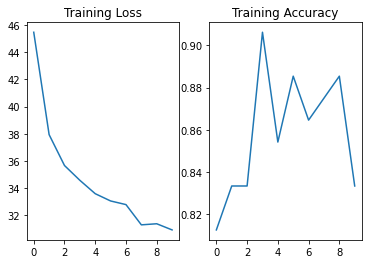

In [13]:
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.plot(tr_loss_vect)
plt.subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(tr_accu_vect)
plt.show()

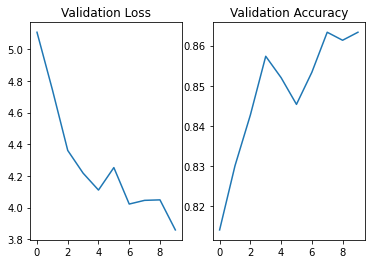

In [14]:
plt.subplot(1,2,1)
plt.plot(val_loss_vect)
plt.title("Validation Loss")
plt.subplot(1,2,2)
plt.plot(val_accu_vect)
plt.title("Validation Accuracy")
plt.show()

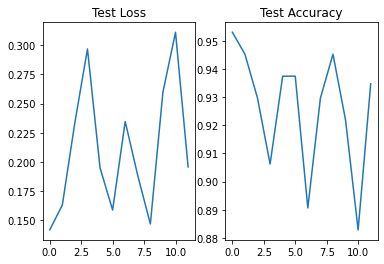

In [15]:
plt.subplot(1,2,1)
plt.plot(tst_loss_vect)
plt.title("Test Loss")
plt.subplot(1,2,2)
plt.plot(tst_accu_vect)
plt.title("Test Accuracy")
plt.show()

In [0]:
def confusion_matrix(y_pred,y_true):
  from sklearn.metrics import confusion_matrix
  tn, fp, fn, tp=confusion_matrix(y_true,y_pred).ravel()
  return tn, fp, fn, tp

In [0]:
def get_confusion_matrix(loader,mdl):
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tn1=0
    tp1=0
    fp1=0
    fn1=0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = mdl(images)
            _, predicted = torch.max(outputs.data, 1)
            tn, fp, fn, tp=confusion_matrix(labels.cpu(),predicted.cpu())
            tn1+=tn
            tp1+=tp
            fp1+=fp
            fn1+=fn
    print("The confusion matrix entries are as follows with gold labels")
    print("Tp =",tp1)
    print("Tn =",tn1)
    print("Fp =",fp1)
    print("Fn =",fn1)
    print("Accuracy = ", (tp1+tn1)/(tp1+tn1+fp1+fn1))
    print("Precision =", tp1/(tp1+fp1))
    pre=tp1/(tp1+fp1)
    recl=tp1/(tp1+fn1)
    print("Recall =",tp1/(tp1+fn1))
    print("F1 Measure",(2*pre*recl)/(pre+recl))
    return

###VGG16 Confusion Matrix Values

In [20]:
print("Confusion Matrix for Training Dataset")
get_confusion_matrix(trainloader,vgg16)
print("Confusion Matrix for Testing Dataset")
get_confusion_matrix(testloader,vgg16)
print("Confusion Matrix for Validation Dataset")
get_confusion_matrix(validationloader,vgg16)

Confusion Matrix for Training Dataset
The confusion matrix entries are as follows with gold labels
Tp = 6390
Tn = 3959
Fp = 691
Fn = 960
Accuracy =  0.8624166666666667
Precision = 0.9024149131478605
Recall = 0.8693877551020408
F1 Measure 0.8855935139629962
Confusion Matrix for Testing Dataset
The confusion matrix entries are as follows with gold labels
Tp = 860
Tn = 536
Fp = 25
Fn = 79
Accuracy =  0.9306666666666666
Precision = 0.9717514124293786
Recall = 0.9158679446219382
F1 Measure 0.9429824561403508
Confusion Matrix for Validation Dataset
The confusion matrix entries are as follows with gold labels
Tp = 794
Tn = 502
Fp = 91
Fn = 113
Accuracy =  0.864
Precision = 0.8971751412429378
Recall = 0.8754134509371555
F1 Measure 0.8861607142857143


### Resnet 18 Code will start from here

In [0]:
res18 = models.resnet18(pretrained=True)

for param in res18.parameters():
    param.requires_grad = False


num_features=res18.fc.in_features

features = list(res18.fc.children())[:-1]

features.extend([nn.Linear(num_features, 550)])
features.extend([nn.Linear(550, len(class_names))])
res18.fc=nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.01, momentum=0.9)

In [0]:
tr_loss_vect,tr_accu_vect,val_loss_vect,val_accu_vect,tst_loss_vect,tst_accu_vect=train_validate_test(res18)

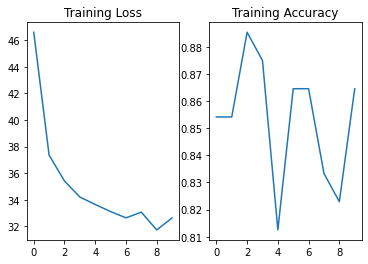

In [24]:
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.plot(tr_loss_vect)
plt.subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(tr_accu_vect)
plt.show()

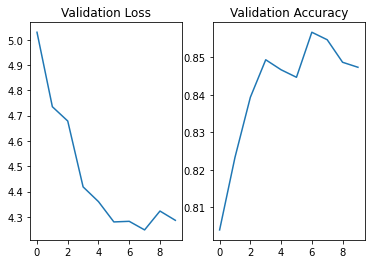

In [25]:
plt.subplot(1,2,1)
plt.plot(val_loss_vect)
plt.title("Validation Loss")
plt.subplot(1,2,2)
plt.plot(val_accu_vect)
plt.title("Validation Accuracy")
plt.show()

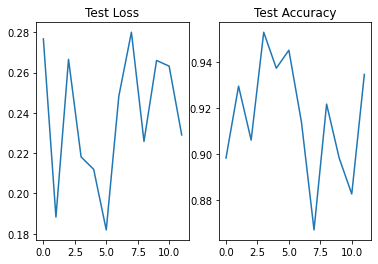

In [26]:
plt.subplot(1,2,1)
plt.plot(tst_loss_vect)
plt.title("Test Loss")
plt.subplot(1,2,2)
plt.plot(tst_accu_vect)
plt.title("Test Accuracy")
plt.show()

In [27]:
print("Confusion Matrix for Training Dataset")
get_confusion_matrix(trainloader,res18)
print("Confusion Matrix for Testing Dataset")
get_confusion_matrix(testloader,res18)
print("Confusion Matrix for Validation Dataset")
get_confusion_matrix(validationloader,res18)

Confusion Matrix for Training Dataset
The confusion matrix entries are as follows with gold labels
Tp = 6200
Tn = 4122
Fp = 881
Fn = 797
Accuracy =  0.8601666666666666
Precision = 0.8755825448382997
Recall = 0.886094040302987
F1 Measure 0.880806932802955
Confusion Matrix for Testing Dataset
The confusion matrix entries are as follows with gold labels
Tp = 811
Tn = 556
Fp = 74
Fn = 59
Accuracy =  0.9113333333333333
Precision = 0.9163841807909604
Recall = 0.9321839080459771
F1 Measure 0.9242165242165242
Confusion Matrix for Validation Dataset
The confusion matrix entries are as follows with gold labels
Tp = 751
Tn = 526
Fp = 134
Fn = 89
Accuracy =  0.8513333333333334
Precision = 0.848587570621469
Recall = 0.8940476190476191
F1 Measure 0.8707246376811595
